In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Rice_Leaf_Disease_Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7795 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[2 2 0 0 0 1 3 3 0 2 2 2 1 3 1 0 1 4 2 1 0 4 3 0 0 4 4 1 3 1 1 3 0 3 2 4 0
 4 2 2 1 3 4 3 0 1 0 1 3 4 4 3 3 2 1 2 1 2 2 1 3 3 0 1]


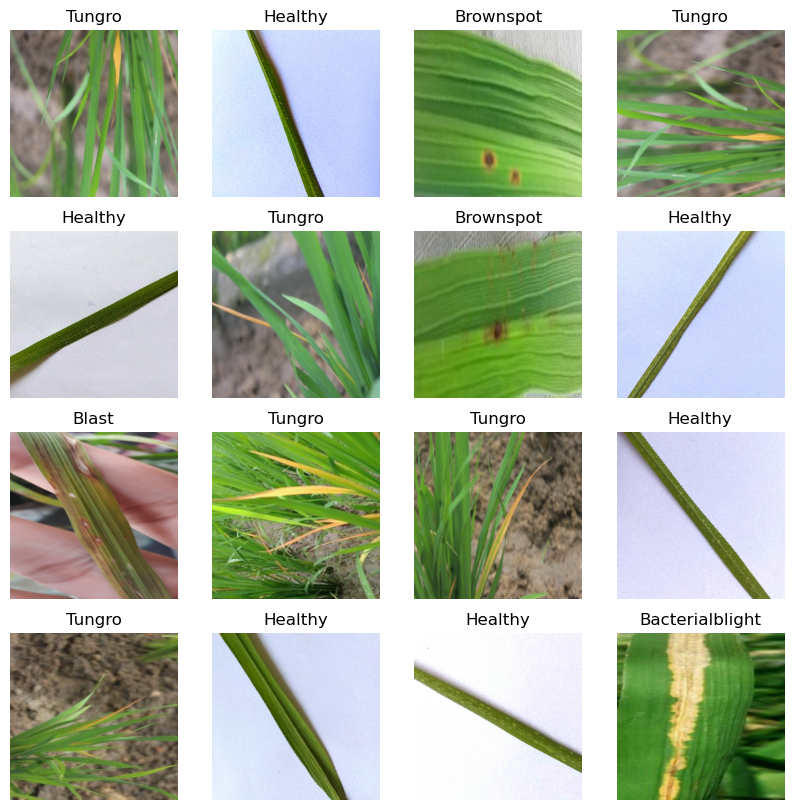

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
# Load pre-trained ResNet50 model
resnet_model = ResNet50(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Freeze all layers in the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = False

# Add custom output layers
x = layers.Flatten()(resnet_model.output)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)

# Create the final ResNet50 model
model = models.Model(inputs=resnet_model.input, outputs=output)

model.summary()

94781440/94765736 [==============================] - 18s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
97/97 [==============================] - 119s 693ms/step - loss: 1.5444 - accuracy: 0.9052 - val_loss: 0.0921 - val_accuracy: 0.9831
Epoch 2/50
97/97 [==============================] - 23s 234ms/step - loss: 0.0790 - accuracy: 0.9919 - val_loss: 0.0380 - val_accuracy: 0.9948
Epoch 3/50
97/97 [==============================] - 18s 189ms/step - loss: 0.0580 - accuracy: 0.9924 - val_loss: 0.0824 - val_accuracy: 0.9883
Epoch 4/50
97/97 [==============================] - 18s 189ms/step - loss: 0.0644 - accuracy: 0.9932 - val_loss: 0.0130 - val_accuracy: 0.9948
Epoch 5/50
97/97 [==============================] - 18s 189ms/step - loss: 0.0146 - accuracy: 0.9979 - val_loss: 0.0094 - val_accuracy: 0.9987
Epoch 6/50
97/97 [==============================] - 18s 190ms/step - loss: 0.0140 - accuracy: 0.9985 - val_loss: 2.0663e-04 - val_accuracy: 1.0000
Epoch 7/50
97/97 [==============================] - 18s 191ms/step - loss: 0.0133 - accuracy: 0.9989 - val_loss: 0.0027 - val_accuracy: 0

In [17]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 48s 183ms/step - loss: 2.2597e-05 - accuracy: 1.0000


In [18]:
scores

[2.259664142911788e-05, 1.0]

In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 97}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
type(history.history['loss'])

list

In [23]:
len(history.history['loss'])

50

In [24]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.5443546772003174,
 0.07896387577056885,
 0.05802995711565018,
 0.06440594047307968,
 0.014584295451641083]

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

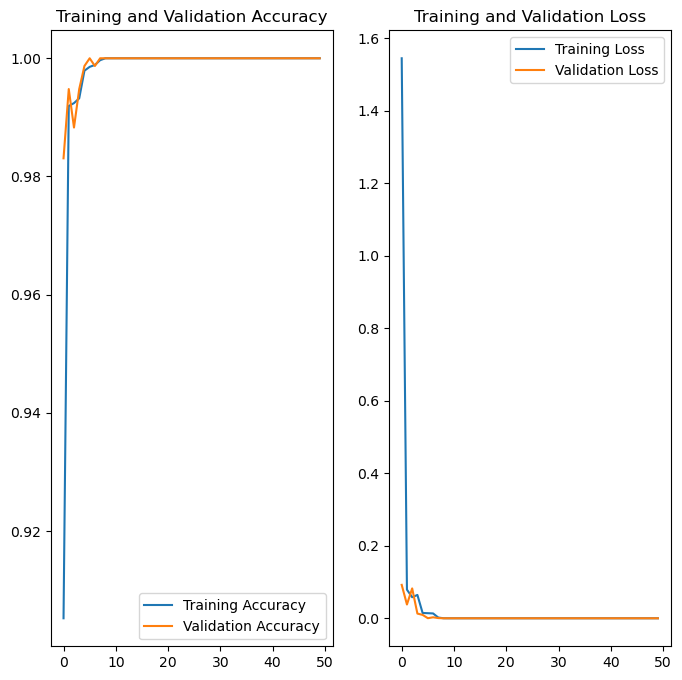

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Brownspot
predicted label: Brownspot


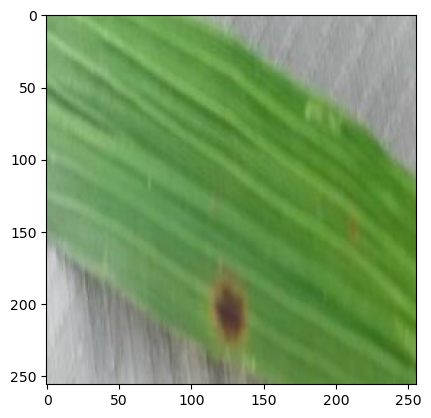

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

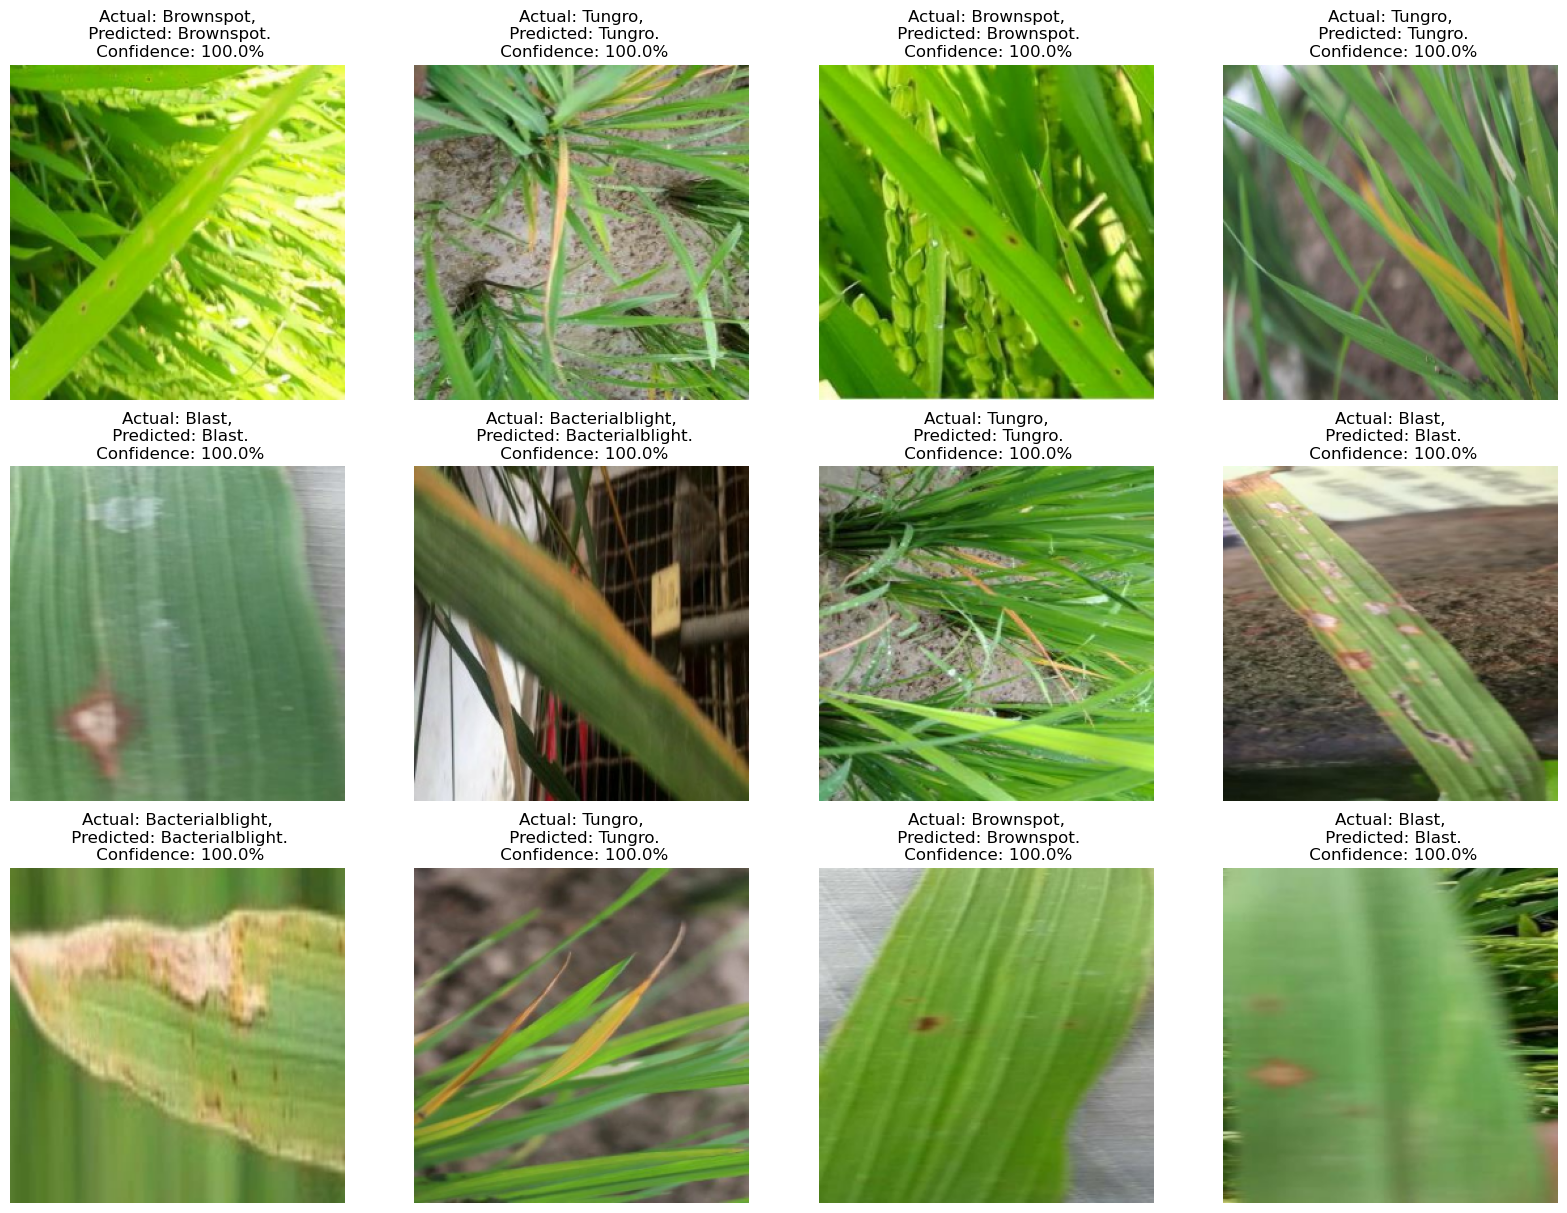

In [38]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [39]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


C:\Users\Mosta\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [40]:
model.save("../rice_resnet.h5")